<a href="https://colab.research.google.com/github/kasparvonbeelen/uga-llm-workshop/blob/main/2_Poking_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using (open-source) LLMs for analysing humanities data

In this notebook, we explore some applications of generative AI to historical newspaper data.

## LLMs as Research Assistants

The overarching questions is: how to merge (information in) historical data with the predictive abilities of language models?

**Language Modelling:** the previous notebook investigated how language models **'absorb'** historical knowledge via continued pre-training on historical data using a language modelling task.

**Instruction Following:** What sets the current generation of language models (ChatGPT, Llama, Claude, etc.) apart from the previous models is their ability to follow instructions, usually based on a given prompt.
- **Few-shot learning/In-context learning**: "I tell you (i.e. the LLM) what to do based on giving a few examples of correct answers."
- **Retrieval Augmented Generation** (RAG): "I fetch a few documents, on which you have to base your answer"

This notebook explores the latter approach, where LLMs are used to "analyse" content in meaningful and often complex ways.

## Why work with historical newspapers?

[Example](https://www.britishnewspaperarchive.co.uk/viewer/BL/0000080/18380701/004/0001?browse=true)

- **Big**: Immense collections of data (if not the largest).
- **Fine-grained**: often daily reports on a myriad of events, from the 'banal' to the 'breaking' news.
- **Longitudinal**: newspapers run for decades (even though their content and formats change over time.

### Case Study: Accidents in the News
#### Or: Using Large Language Models to Investigate "Small" People

![](https://global.oup.com/academic/covers/pop-up/9780198732334)

Inspired by Paul Fyfe's book: ["By Accident or Design"](https://global.oup.com/academic/product/by-accident-or-design-9780198732334?cc=us&lang=en&)

- We treat newspapers as periodical purveyors of miscellaneous content: “A newspaper without an account of one or more accidents . . . is scarcely ever taken up”
- Accident reports are “subjective attempts at the construction of evidence” (Roger Cooter) and “useful as indices to social and especially industrial change” (Roger Lane).

## 'Baby' RAG (Or elevated copy-pasting)

The "I tell you what to do" is usually referred to a "prompt" which we ask the LM to "complete" (sometimes using few-shot learning).

**Q: How can we inject historical data in this process?**

**A: Retrieval Augmented Generation**: We ask the LLM to answer questions based on historical content that we "copy-paste" into our prompt.

- Given a query, something we want to know
- We select documents from our database that might contain the answer to this question
- Then we use the language model to generate an answer based on the documents we retrieved.

We focus on the "generation" less on the "retrieval". We want to keep things simple (at the technical level)!

## Open Source LLMs

### [Ollama](https://ollama.com/)

We will be largely playing with an open-source model, **Llama-3-Instruct**, to get a feeling of how LLMs change the way we can interrogate historical data.

Many of the popular, commercial models are "closed" in the sense that even though you can interact with them, they remain "hidden", i.e. you can not "download" them or freely run and manipulate them on your own computer system.


### Why Open-source?

- **Privacy:**: You might not want to share your data (and ideas) with companies such as OpenAI;
- **Cost:** Making abstraction of the caveat above, using open-source models might reduce costs if you want to apply for example a prompt to 10k newspaper articles;
- **Transparency:** Be mindful that there are different gradations of openness and transparency. Even when you can access the model weights, you might remain in the dark about training data and other factors);
- **Flexibility:** Although some providers allow you to train or fine-tune closed models on your data (ties in with privacy), open-source models still give you more freedom and wiggle room to build new models and applications.

### Technical note

We will rely on the Hugging Face `InferenceClient` to access LLMs. These are freely accessible, but rate limits apply! If you would want to deploy a 'local' version (we're still on Colab, but the code should also work on your computer), uncomment the code below (where indicated) and make sure you are using a [GPU](https://cloud.google.com/gpu). To select a GPU on Colab, Go to **`Runtime`** and select **`Change runtime type`**, then select `T4 GPU` (or any other GPU available).



This notebook is inspired by: https://huggingface.co/learn/cookbook/structured_generation

## The Hugging Face Hub

In the examples below, we will experiment with `Llama-3-8B-Instruct`, a recent series of open-source LLMs created by Meta. To use Llama3, you need to:

- Make an account on Hugging Face: https://huggingface.co/
- Go to the Llama-3-8B and sign the terms of use you should get a reply swiftly: https://huggingface.co/meta-llama/Meta-Llama-3-8B
- Create a user access token with at least read access: https://huggingface.co/docs/hub/en/security-tokens
- Run the code cell below to log into the Hugging Face hub. Copy-paste the access token.
- Reply `n` to the question 'Add token as git credential? (Y/n)'

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Preparing model and data

### Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore') # disable warnings

In [ ]:
import transformers
from huggingface_hub import InferenceClient
#from datasets import Dataset
from tqdm import tqdm
import pandas as pd
import torch
import pandas as pd
import json
pd.set_option("display.max_colwidth", 100)

### Load model

In [ ]:
# choose a LLMs model
repo_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# instantiate the inference client
llm_client = InferenceClient(model=repo_id, timeout=120)

In [ ]:
# # use this cell if you can access an A100 or L4 GPU
# # define the model, we use the instruct variant
# checkpoint = "meta-llama/Meta-Llama-3-8B-Instruct"
# device = 'cuda' # make sure you use a GPU

# # instantiate a text generation pipeline
# pipeline = transformers.pipeline(
#     "text-generation",
#     model=checkpoint,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device="cuda",
# )

# # some fluff to improve the generation
# terminators = [
#     pipeline.tokenizer.eos_token_id,
#     pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
# ]

In [ ]:
# # use this cell if you can only access a T4 GPU
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
# # define the model, we use the instruct variant
# checkpoint = "meta-llama/Meta-Llama-3-8B-Instruct"
# device = 'cuda' # make sure you use a GPU if available

# bnb_confic = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# #tokenizer.pad_token = tokenizer.eos_token
# model = AutoModelForCausalLM.from_pretrained(checkpoint,
#                                              quantization_config=bnb_confic,
#                                              device_map='auto')

# pipeline = transformers.pipeline(
#     "text-generation",
#     model=model,
#     tokenizer= tokenizer,
# )


# # some fluff to improve the generation
# terminators = [
#     pipeline.tokenizer.eos_token_id,
#     pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
# ]

## Prompting

LLM generate text from an input, usually referred to as a 'prompt', a piece of text we like the model to use as a starting point for predicting novel tokens.

When 'chatting' with an LLM, we usually provide the model with (at least) two messages: a system and a user prompt or message.

**System message**:

- **Generic instructions on behaviour**: specify how the model should behave (e.g. be helpful, respectful, neutral) or the role it should play (e.g., a teacher, assistant, or advisor).
- **Constraints**: Specific instructions on what the model should avoid or how it should generate responses.
- **Context**: Background information or context that remains constant throughout the session to ensure consistency.

**User message**:

- **Query**: specifies input from the user, such as a question, instruction, or request that the model needs to respond to.
- **Dynamic**: changes with each interaction, reflecting the user's immediate needs, questions, or instructions.

The Hugging Face chat prompt template allows messages as lists of dictionaries.

```python
messages [
 {
    "role" : "system",
    "content": "<system prompt here>"
 },
 {
    "role" : "user",
    "content": "<user prompt here>"
 }
]
```

## RAG by hand

Define a message by articulating a system and user prompt.

In [ ]:
messages = [
    {
        "role": "system",
        "content": """
          You are a helpful AI that will assist me with analysing and reading newspaper articles.
          Read the newspaper article attentively and provide a short description of principal characters.
          The newspaper article is enclosed within triple hashtags (i.e. ###).
          Don't make things up! If the information is not in the article then reply 'I don't know'
          """
              },

    {
        "role": "user",
        "content": f"""
                  ###POOR T,i,ENIPAT A 1„k CT  The Poor Law Coirdnissioti(rs have issued a ei; cular,
                  dated the 20th instant, stating that they have consulted the Attorney and
                  Solicitor-General on the construction of the late Removal Act, and give as the
                  result:— I. " That the proviso to the Ist section of the 9 and 10 Vict., c. 66,
                  which sets forth the exceptions to the principal enactments that are to be
                  excluded in the computation of time, is net retrospective in its operation, so
                  as to apply to cases where the five years\' residence was complete before the statute.
                  2. " That an interval between the completion of the five years residence and the
                  application for the warrant of removal filled up by one of the exceptions contained
                  in the proviso will not p event the operation of the statute in restraining the
                  removal of the pauper whu had resided for the specified time. 3. " That orders
                  of removal obtained previous to th• passing of the Act, but not then executed
                  by the removal of the paupers,###"""
              }
  ]

In [ ]:
messages

[{'role': 'system',
  'content': "\n          You are a helpful AI that will assist me with analysing and reading newspaper articles.\n          Read the newspaper article attentively and provide a short description of principal characters.\n          The newspaper article is enclosed within triple hashtags (i.e. ###).\n          Don't make things up! If the information is not in the article then reply 'I don't know'\n          "},
 {'role': 'user',
  'content': '\n                  ###POOR T,i,ENIPAT A 1„k CT  The Poor Law Coirdnissioti(rs have issued a ei; cular,\n                  dated the 20th instant, stating that they have consulted the Attorney and\n                  Solicitor-General on the construction of the late Removal Act, and give as the\n                  result:— I. " That the proviso to the Ist section of the 9 and 10 Vict., c. 66,\n                  which sets forth the exceptions to the principal enactments that are to be\n                  excluded in the computati

In [ ]:
#help(llm_client.chat_completion)

In [ ]:
# # uncomment this code if you want to work locally, comment the other function
# def get_completion(messages: list, temperature=.1, top_p=.1) -> str:
#   """get completion for given system and user prompt
#     Arguments:
#     messages (list): a list containin a system and user message as
#       python dictionaries with keys 'role' and 'content'
#     temperature (float): regulate creativity of the text generation
#     top_p (float): cummulative probability included in the
#       generation process
#   """
#   prompt = pipeline.tokenizer.apply_chat_template(
#         messages,
#         tokenize=False,
#         add_generation_prompt=True
#       )

#   outputs = pipeline(
#     prompt,
#     max_new_tokens=256,
#     eos_token_id=terminators,
#     do_sample=True,
#     temperature=temperature,
#     top_p=top_p,
#       )
#   return outputs[0]["generated_text"][len(prompt):]

# uncomment this if you are using the llm_client
def get_completion(messages: list, temperature=.0, top_p=.1,grammar=None):
    """get completion for given system and user prompt
      Arguments:
        messages (list): a list containin a system and user message as
          python dictionaries with keys 'role' and 'content'
        temperature (float): regulate creativity of the text generation
        top_p (float): cummulative probability included in the
          generation process
    """
    outputs = llm_client.chat_completion(
        messages=messages,
        max_tokens=1024,
        temperature=temperature,
        top_p=top_p
        )
    return outputs.choices[0].message.content

In [ ]:
print(get_completion(messages))

Based on the newspaper article, the principal characters mentioned are:

1. The Poor Law Commissioners: They are the ones who issued the circular and consulted with the Attorney and Solicitor-General on the construction of the Removal Act.
2. The Attorney-General: He was consulted by the Poor Law Commissioners on the construction of the Removal Act.
3. The Solicitor-General: He was also consulted by the Poor Law Commissioners on the construction of the Removal Act.
4. Paupers: They are the individuals who are the subject of the Removal Act and are being discussed in the circular.

Note: There are no specific individuals mentioned in the article, only these groups or roles.


## Exercise

- Change the system message and ask the model to perform another taks, for example translate to pirate English, summarize the text or something silly!
- Change the user message, for inspiration you can go to the British Newspaper Archive, go to ["Advanced Search"](https://www.britishnewspaperarchive.co.uk/search/advanced) and select "Free To View"

In [1]:
messages = [
    {"role": "system", "content": """ENTER PROMPT HERE"""
          },
    {"role": "user", "content": f"""###ENTER CONTENT HERE###"""}
]

print(get_completion(messages))


### Download data

We will be experimenting with a small set of 10k British newspaper articles provided by the ["Living with Machines"](https://livingwithmachines.ac.uk/public-domain-newspaper-titles-in-living-with-machines/) project.

In [ ]:
# download a sample of 10.000 newspaper articles
!gdown 1cewugDdehGn-wPP9B4kTBg_Wmu-14aHq
# unzip the downloaded sample
!unzip -o 0002247.csv.zip
!rm -r __MACOSX

Downloading...
From (original): https://drive.google.com/uc?id=1cewugDdehGn-wPP9B4kTBg_Wmu-14aHq
From (redirected): https://drive.google.com/uc?id=1cewugDdehGn-wPP9B4kTBg_Wmu-14aHq&confirm=t&uuid=0a29d222-3fe7-4c62-936c-6d2f7d891f5c
To: /content/0002247.csv.zip
100% 82.8M/82.8M [00:01<00:00, 71.5MB/s]
Archive:  0002247.csv.zip
  inflating: 0002247.csv             
  inflating: __MACOSX/._0002247.csv  


In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/kasparvonbeelen/uga-llm-workshop/refs/heads/main/newspapers/0002247.csv',index_col=0)
# df.head(3)

,Unnamed: 0,title,item_type,ocr_quality_mean,date,content
8443,0002247/1866/0303/0002247_18660303_art0082_metadata.xml,",",ARTICLE,0.7092,1866-03-03,",\n\nThe dir\n\ndifference\n\n7 per cen\nBiraCe last\n\nThe Loi\nearnings of\nPay 4! per\n412 la..."
27527,0002247/1867/0216/0002247_18670216_art0045_metadata.xml,APPLICATIONS.,ARTICLE,0.9435,1867-02-16,APPLICATIONS.\n\nThe members of Blackburn Lodge desire the sanction\nof the Union to enable them...
20920,0002247/1864/0618/0002247_18640618_art0020_metadata.xml,NAVAL AND MILITARY.,ARTICLE,0.9647,1864-06-18,"NAVAL AND MILITARY.\n\nThe Wolverine, ironcased corvette, and the Research\nand Enterprise, rams..."


In [ ]:
df = pd.read_csv('0002247.csv')
df.head(3)

,Unnamed: 0,title,item_type,ocr_quality_mean,date,content
0,0002247/1869/0320/0002247_18690320_art0001_metadata.xml,NaN,ARTICLE,0.8326,1869-03-20,"new EDIN BORO\nthe fa3hionable Oliva an 4 Brown\nis, and fa,:ed 30s ,\n\nlew GLADSTONB\n\nelegan..."
1,0002247/1869/0320/0002247_18690320_art0023_metadata.xml,SINGULA_R DisT'URBANCES.,ARTICLE,0.9487,1869-03-20,"SINGULA_R DisT'URBANCES.\n\nFor upwards of 12 months the Scotch church in\nMidvale-road, St. Hel..."
2,0002247/1869/0320/0002247_18690320_art0065_metadata.xml,BUILDERS' TENDERS.,ARTICLE,0.9288,1869-03-20,"BUILDERS' TENDERS.\n\nFor residence near Kettering. Mr. R. W. Johnson, architect—.\nBarlow & But..."


In [ ]:
df.shape

(35999, 6)

### Issues with the data

- Segmentation: ["what is an article"](https://docs.google.com/document/d/1fbfWaDx6P-VV09j7pC__Rez_WVJOnnhq4RS-yiQ-XBM/edit?usp=sharing)
- OCR Quality: 6ibb*riSH?

In [ ]:
print(df.iloc[0].content)

new EDIN BORO
the fa3hionable Oliva an 4 Brown
is, and fa,:ed 30s ,

lew GLADSTONB

elegant and anterior Garment, cut
s extant, and in a large variety of
ded, and Seams 355.



In [ ]:
print(df.iloc[10].content)

BIRMINGHAM.

THE GUN TRADE.—A meeting of operatives engaged
in the small arms manufacture, and who tire resident
in the Small Heath district of Birmingham, was held on
Tuesday nicht, " to consider what steps shall be taken
to reduce the Government small arms factory at En-
field, and thus bring the trade back to Birmingham. "
Mr. E. Frazer presided. The chairman complained in
gcneral terms of the circumstance of the Government
having become manufacturers ; he suggested that rather
than the present system should continue it would be
desirable that all Government work should be thrown
open to general competition. A Mr. Monk next ad-
'dressed the meeting. He alluded to the recent deputation
to London to hold conference with Mr. Bright and other
local members of the Legislature, and said that the
continuance of the Enfield minnfactory threatened the
extinction of the small arms trade in Birmingham,
where it has flourished for a period of nearly 200 years.
He counselled all present to give 

### Process data

To facilitate the analysis, we divide the newspaper articles into smaller, hopefully more meaningful chunks of 250 words (with a 50-word overlap).

- We split by proxy article (i.e. double hard returns)
- Remove single hard returns from the proxy articles.

In [ ]:
def get_chunks(text: str, size: int=250,step: int=50) -> list:
  """divide a text into chunks of similar size
  Arguments:
    text (str): input text
    size (int): number of tokens in each chunk
    step (int): step size
  Returns a list of strings
  """
  words = text.split()
  return [' '.join(words[i:i+size]) for i in range(0,len(words),step)]

In [ ]:
# split by proxy-article
df['elements'] = df.content.apply(lambda x: [' '.join(ch.split('\n')) for ch in x.split('\n\n')])
# reorder the dataframe
# with one chunk in each row
# instead of the whole text
df_by_element = df.explode('elements')
# # apply chunking to text
df_by_element['chunks'] = df_by_element.elements.apply(lambda x: get_chunks(x))
df_chunks = df_by_element.explode('chunks')
df_chunks.reset_index(drop=True, inplace=True)
df_chunks.shape # wow that's a lot of chunks ;-)

(819814, 8)

In [ ]:
len(df_by_element.iloc[110].elements),len(df_by_element.iloc[110].chunks)

(2579, 9)

In [ ]:
df_chunks.iloc[5].chunks

'a vete of the majority of the congregation. Since that period the church has been served with supplies sent by the London Presbytery. At length a call wal given by the church to the Rev. J. J. Muir, whose induction was appointed to take place on the 4th inst. The call was not acceptable to many members of the coniregation, and they resolved if possible to prevent the induction taking place. Accordingly on the morn- ing of the above day the gates of the church were padlocked by two of the trustees, but the locks were afterwards removed and the service proceeded. A sermon was preached by the Rev. Robert Taylor, of Camber- well, and the induction service was conducted by the Rev. G. Carlisle, Moderator of the London Presbytery. At the conclusion of this portion of the service a sin. gular occurrence took place. In the mitist of a crowded congregation one of the trustees, Mr. Clash, rose from his seat, advanced to the aisle, kneeled down, and cried out, " Ham, Hap, a mon aide, mon ! On me

## Retrieving articles about accidents

In [ ]:
import re
pattern = re.compile(r'\baccidents?\b', re.I) # compile a regex
pattern.findall('accidents accident AccIdent accidental') # test the regex on a few example


['accidents', 'accident', 'AccIdent']

In [ ]:
tqdm.pandas()
df_chunks['chunk_count'] = df_chunks.progress_apply(lambda x: len(pattern.findall(str(x['chunks']))), axis=1)
df_chunks['title_count'] = df_chunks.progress_apply(lambda x: len(pattern.findall(str(x['title']))), axis=1)

100%|██████████| 819814/819814 [00:05<00:00, 157825.11it/s]


In [ ]:
df_chunks.sort_values('chunk_count', ascending=False)[['title','chunk_count','title_count','chunks']][:10]

,title,chunk_count,title_count,chunks
486218,"BEE-HIVE, SATURDAY, AUGUST 6, 1864",9,0,ACCIDENTS IN •Al INEB.—In the year 1863 there were 907 deaths caused by accidents in and about t...
333681,RAILWAY ACCIDENTS IN AMERICA.,7,1,"The record of fatal accidents on the railroads in Eng- land, which is published annually, with t..."
9546,SOUTHWARK PARK.,6,0,ANOTHER ACCIDENT TO 11.111.5. BARROSA.—Another accident occurred to H.M.S. Barrosa on the 18th i...
815234,it/4. sup',6,0,little for it as he can. He never visits a pit when he dares to stop away. He never makes a tour...
637504,"RDAY, DECEMBER 28, 1867.",6,0,I lose ?—Yes I should. like to mention this case. A. 'slim came to London from Wolverhampton tri...
637503,"RDAY, DECEMBER 28, 1867.",6,0,", wovld be entitled to the benefits. They re- rted them as if they did not owe anything. gr. Roe..."
637502,"RDAY, DECEMBER 28, 1867.",6,0,"were out of emploYment F—No, it was &Ise they were using the money for the strike ad of paying t..."
486219,"BEE-HIVE, SATURDAY, AUGUST 6, 1864",6,0,"shafts, 134 by miscellaneous underground accidents, and 56 by accidents at the surface. There we..."
403071,EXPLOSION AT CHILWORTH.,6,0,"respect of the s ifety to life and limb—a question which, on the recurrence of each railway acci..."
135481,"lI.EAV I DADIAG-ES l'Ult A ItAILW A ACCIDENT. • ,",6,1,"accident. The case was a very peauliar one. The accident took place at Copley Hill, Leeds, so fa..."


## Applying text generation to historical documents


### Step 1: Classify (and Clean)
#### Selecting and processing newspaper data

- Not all snippets (or chunks) that mention accidents are necessarily relevant, i.e. "about accidents".
- We can use Llama 3 to **classify** (and clean the data) using "few-shot learning".

Let's select ten chunks that mention 'accidents' most often (by way of example). Running the models can take quite some otherwise.

In [ ]:
df_chunks.chunk_count.value_counts(normalize=False)

,count
chunk_count,
0,800472
1,15311
2,3377
3,512
4,105
5,23
6,12
7,1
9,1


In [ ]:
df_accident = df_chunks.sort_values('chunk_count',ascending=False)[:10]
df_accident[['title','chunk_count','title_count','chunks']]

,title,chunk_count,title_count,chunks
486218,"BEE-HIVE, SATURDAY, AUGUST 6, 1864",9,0,ACCIDENTS IN •Al INEB.—In the year 1863 there were 907 deaths caused by accidents in and about t...
333681,RAILWAY ACCIDENTS IN AMERICA.,7,1,"The record of fatal accidents on the railroads in Eng- land, which is published annually, with t..."
9546,SOUTHWARK PARK.,6,0,ANOTHER ACCIDENT TO 11.111.5. BARROSA.—Another accident occurred to H.M.S. Barrosa on the 18th i...
815234,it/4. sup',6,0,little for it as he can. He never visits a pit when he dares to stop away. He never makes a tour...
637504,"RDAY, DECEMBER 28, 1867.",6,0,I lose ?—Yes I should. like to mention this case. A. 'slim came to London from Wolverhampton tri...
637503,"RDAY, DECEMBER 28, 1867.",6,0,", wovld be entitled to the benefits. They re- rted them as if they did not owe anything. gr. Roe..."
637502,"RDAY, DECEMBER 28, 1867.",6,0,"were out of emploYment F—No, it was &Ise they were using the money for the strike ad of paying t..."
486219,"BEE-HIVE, SATURDAY, AUGUST 6, 1864",6,0,"shafts, 134 by miscellaneous underground accidents, and 56 by accidents at the surface. There we..."
403071,EXPLOSION AT CHILWORTH.,6,0,"respect of the s ifety to life and limb—a question which, on the recurrence of each railway acci..."
135481,"lI.EAV I DADIAG-ES l'Ult A ItAILW A ACCIDENT. • ,",6,1,"accident. The case was a very peauliar one. The accident took place at Copley Hill, Leeds, so fa..."


Run the cell below to load the `apply_completions` function.

In [ ]:
def apply_completions(item: pd.Series,
                      system_message: str,
                      user_message: str='',
                      text_column: str = 'chunks') -> str:
  """
  Function that appl
  Argument:
    item (pd.Series): row from a pandas Dataframe
    system_message (str): system prompt, specifies how the system
      should behave in
    user_message (str): user prompt, give instruction how to
      process each historical. the documents itself will be append
      from the 'text_column' argument
    text_column (str): name of the text column
  """
  messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_message}
      ]
  messages[1]['content'] += f"\n\n###{item[text_column]}###"
  return  get_completion(messages)

We apply the prompt to the text chunks in our dataframe.

In [ ]:
tqdm.pandas() # use tqdm to view progress

system_message = """You are a document classifier that will clean and correct
    snippets of newspaper articles  as either about accidents or not about accidents.
    You answer with only 'yes', 'no', or 'unsure'.

    Examples are:
    Input: RAILWAY ACCIDENTS IN AMERICA. The record of fatal accidents on the railroads in Eng- land, which is published annually,
    Output: yes

    Input: LATEST INTELL IGEN CE. the prisoner was committed for trial for embezzlement. He was also further committed in two
    Output: no

    """

df_accident['classification'] =  df_accident.progress_apply(apply_completions,system_message=system_message, axis=1)

100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


In [ ]:
#print the summaries
df_accident['classification'].value_counts()

,count
classification,
yes,9
no,1


In [ ]:
df_accident[df_accident["classification"]== 'no'].chunks.values

array(["were out of emploYment F—No, it was &Ise they were using the money for the strike ad of paying the contributions to the Qxecutive 5.61, and that executive council being members e Manchester lodge kept them straight with the 1, so that if there were any accidents or deaths, , , wovld be entitled to the benefits. They re- rted them as if they did not owe anything. gr. Roebuck: So that the executive council Isified the accounts P—Yes, they did not issue a per report, it was a false report 7,arl of Lichfield: You will put in these rules I lose ?—Yes I should. like to mention this case. A. 'slim came to London from Wolverhampton trike. They had a lodge at Wolverhamp . Illk of the Manchester Society and of the Deiety, and the London Society men closed :e without the sanction of the Manchester A. deputation then came up to London, and ut £l2O. They entered half of that to eport and half of it to the accident report; d £6O to the accident aceount,for coming 1)n to look after the strike

In [ ]:
tqdm.pandas() # use tqdm to view progress

system_message = """You are a document will clean and correct snippets of newspaper articles that mention the word 'accident'.
    Remove all text that is not about accidents, i.e. mention other events or facts that are not about accidents.
    Try to correct errors in the text wherever possible.
    Examples are:
    Input: "RAILWAY ACCIDENTS IN AMERICA. The record of fatal accidents on the railroads in Eng- land, which is published annually,
            POOR T,i,ENIPAT A 1„k CT  The Poor Law Coirdnissioti(rs have issued a ei; cular, dated the 20th instant, stating that they have consulted the Attorney and"
    Output: "RAILWAY ACCIDENTS IN AMERICA. The record of fatal accidents on the railroads in England, which is published annually."

    Input: "LATEST INTELL IGEN CE. the prisoner was committed for trial for embezzlement. He was also further committed in two"
    Output: ""
    """

df_accident['clean'] =  df_accident.progress_apply(apply_completions,system_message=system_message, axis=1)

100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


In [ ]:
df_accident['clean']

,clean
486218,"Here is the cleaned and corrected text:\n\n""ACCIDENTS IN COAL MINES.—In the year 1863 there were..."
333681,"Here is the cleaned and corrected text:\n\n""The record of fatal accidents on the railroads in En..."
9546,Here is the cleaned and corrected text:\n\n###ANOTHER ACCIDENT TO H.M.S. BARROSA.—Another accide...
815234,"Here is the cleaned and corrected text:\n\n""The inspector is bound to attend all inquests of dea..."
637504,"Here is the cleaned and corrected text:\n\n""...and the London Society men closed without the san..."
637503,"Here is the cleaned and corrected text:\n\n""...and half of it to the accident report; £60 to the..."
637502,"Here is the cleaned and corrected text:\n\n""...and that executive council being members of Manch..."
486219,"91 deaths caused by accidents in and about the inspected ironstone mines of Great Britain, 14 le..."
403071,"Here is the cleaned and corrected text:\n\n""Of the 3,811,878 trains, 51 met with accidents; 44 o..."
135481,"Here is the cleaned and corrected text:\n\n""The accident took place at Copley Hill, Leeds, on Oc..."


We can remove the annoying boilerplate text such as "Here is the cleaned and corrected text:\n\n".

In [ ]:
df_accident['clean_article'] = df_accident['clean'].apply(lambda x: x.split(':\n\n')[-1].strip('#'))
df_accident['clean_article']

,clean_article
486218,"""ACCIDENTS IN COAL MINES.—In the year 1863 there were 907 deaths caused by accidents in and abou..."
333681,"""The record of fatal accidents on the railroads in England, which is published annually, with th..."
9546,ANOTHER ACCIDENT TO H.M.S. BARROSA.—Another accident occurred to H.M.S. Barrosa on the 18th inst...
815234,"""The inspector is bound to attend all inquests of death from accidents in pits held in this dist..."
637504,"""...and the London Society men closed without the sanction of the Manchester A. deputation then ..."
637503,"""...and half of it to the accident report; £60 to the accident account, for coming in to look af..."
637502,"""...and that executive council being members of Manchester lodge kept them straight with the fun..."
486219,"91 deaths caused by accidents in and about the inspected ironstone mines of Great Britain, 14 le..."
403071,"""Of the 3,811,878 trains, 51 met with accidents; 44 of the accidents were to passenger trains; a..."
135481,"""The accident took place at Copley Hill, Leeds, on October 16, 1867. The plaintiff was permanent..."


Another useful example is **summarisation.**

In [ ]:
tqdm.pandas()

system_message = """You are a helpful AI that will help analysing newspaper articles that mention the word 'accident'.
    Provide a short summary about the accident mentioned in the article, focussing on places, people and machines mentioned.
    """

df_accident['summary'] =  df_accident.progress_apply(
                                  apply_completions,
                                  system_message=system_message,
                                  text_column='clean_article',
                                  axis=1
                                )

100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


In [ ]:
df_accident['summary_clean'] = df_accident['summary'].apply(lambda x: x.split(':\n\n')[-1])

In [ ]:
print(df_accident['clean'].iloc[9])

Here is the cleaned and corrected text:

"The accident took place at Copley Hill, Leeds, on October 16, 1867. The plaintiff was permanently disabled in November 1863, thirteen months after the accident. The question in dispute was whether the paralysis resulted from the accident. The defendants contended that it was too remote from the time of the collision to have been caused by it. On the other side, it was maintained that from the time of the accident the plaintiff gradually became worse, until the final seizure, and that there was a continuity of symptoms throughout. Eminent medical men were called on each side who directly contradicted each other as to paralysis resulting from the accident."


In [ ]:
print(df_accident['summary_clean'].iloc[9])

* Place: Copley Hill, Leeds
* People: The plaintiff (name not mentioned) who was permanently disabled due to the accident
* Machines: None mentioned in the article

The accident occurred on October 16, 1867, and the plaintiff suffered paralysis as a result. The article discusses the dispute over whether the paralysis was caused by the accident, with the defendants arguing that it was too remote in time and the plaintiff's lawyers arguing that there was a continuity of symptoms from the time of the accident.


### Step 2: Structuring Information

The previous step helps us **prepare** data but not with the **analysis**.

One problem with RAG—as we introduced it so far—is that it remains **document-focused**, i.e. it extracts information from a sample of texts, which it uses to generate an answer.

**RAG is dominated by a Q&A paradigm which might be less useful for digital historians.** There are a few issues to discuss if we want to make RAG more useful for computational and historical analysis.

**Scale**: How can the "LLM as Research Assistant" paradigm help us with collections at a larger scale? For example, address questions such as: How did accidents in the news change over time? Who is involved in or blamed for the accidents? What are the locations where accidents take place? We could copy-paste all the articles in one prompt, but that is unlikely to work for multiple reasons.

**Text-in-text-out**: In one sense, using LLMs displaces (but does not solve) the problem of analysing text at a large scale. We simply move from input to output text, from article context to completions (correction, summaries, etc.)—except in the classification example, but this is not novel.

One solution I want to demonstrate in this workshop is the use of **structured completions**, using LLMs to go from unstructured text to structured information, which is more amenable to (quantitative) analysis.

Let's make this clear with a concrete example!


#### Structured Generation

Working with verbose and unstructured responses is difficult. Fortunately, we can ask the LLM to respond in a **structured fashion** that we can process more easily.

Let's have a look at how to extract structured **biographical information** from newspaper articles.

History is (often but not exclusively) about **people**.

Newspapers contain a lot of biographical information. In accident reports, we do get some background information about the people involved, implicitly (gender) or explicitly (professions or age). **Who are the victims involved in these news reports?** What stories can we tell based on these reports?

Below, we use a language model to extract biographical information from newspaper reports and return it in a specified, structured format, which allows us to analyse accidents reports as structured data.

### Writing a system prompt for structured generation

We rewrite the system prompt and give it a few more instructions on how to respond to our queries.
- We explain the **task** in natural language
- We make explicit the **structure** we expect

In [ ]:
system_message = """
    You are an helpful AI for analysing historical newspaper articles.
    Extract biographical information from a newspaper article between ###
    Return the biographical as a list of Python dictionaries.
    The information MUST be extracted from the newspaper articles, with spelling and wording identical to the source.
    This list of dictionaries should begin with a "START" tag and end with a "END" tag.
    Don't make thigs up! If you don't know the answer, simply return an empty list, i.e. [].


    Input:
    ###J. D. McPhill, a miner aged 58, died tragically in a railway accident, in which his wife M. M. McBilly, age 59, was also injured.###

    Output:
    START
    [
        {
          "name" : "J. D. McPhill",
          "gender" : "male",
          "profession" : "miner",
          "age" : 58,
          "outcome": "died",
          "cause": "railway accident"

        },
        {
          "name" : "M. M. McBilly",
          "gender" : "female",
          "age" : 58,
          "outcome": "injured",
          "cause": "railway accident"
        }

    ]
    END

    Input:
    """



In [ ]:
# input
snippet = df_chunks.sort_values('chunk_count',ascending=False).iloc[100].chunks; snippet

'FATAL BOAT ACCIDENT.—GREAX YARMOUTH, Tues- day.—A sad accident occurred at Gorlesxn yesterday afternoon, resulting in the loss of two beachmen, and the natrow escape of a third. It seems that William Todd, aged 26, his brother Enfield Todd, aged about 20, and another bea,chmart, mimed Samuel E. Fleming, 20, proceeded out of the harbour in a new boat, tor "the purpose of drawing for some smelts and other fish along the shore. Just as they reached tho bar, and precisely where the late life boat catastrophe took place, their small omit was caught by a sea and swamped. The men were thrown into the water, and being heavily attired, two of them sank and were drowmed ; while Enfield Todd manit,ged to extricate himself, and swam to the beach. The accident was observed from the north pier by some pilots, and they at once launched a boat and proceeded to the scene of the disaster, but too late to be of service. Subsequently the boat was picked up, and the body of the elder Todd was found entang

In [ ]:
# output
messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": f'\n\n###{snippet}###'}
      ]

completion = get_completion(messages)
print(completion)

START
[
    {
      "name" : "William Todd",
      "gender" : "male",
      "age" : 26,
      "outcome": "drowned",
      "cause": "boat accident"
    },
    {
      "name" : "Samuel E. Fleming",
      "gender" : "male",
      "age" : 20,
      "outcome": "drowned",
      "cause": "boat accident"
    },
    {
      "name" : "Enfield Todd",
      "gender" : "male",
      "age" : "about 20",
      "outcome": "injured",
      "cause": "boat accident"
    }
]
END


Let's now apply this prompt to a larger and different set of newspaper articles.

In [ ]:
df_small = df_chunks.sort_values('chunk_count',ascending=False)[100:125]
df_small['bio'] =  df_small.progress_apply(apply_completions,system_message=system_message, axis=1)

100%|██████████| 25/25 [01:14<00:00,  2.98s/it]


In [ ]:
#df_small = pd.read_json('https://raw.githubusercontent.com/kasparvonbeelen/uga-llm-workshop/refs/heads/main/newspapers/articles_with_bio.json')

In order to convert the response from the LLM (which is just a text) to a structured Python object, we need to write a small additional function `eval_completion`.

In [ ]:
# load a function for parison the output
from typing import List, Dict

def eval_completion(completion: str) -> List[Dict]:
  """Convert the completion as string to a Python list of dictionaries
  Argument:
      completion (str): structured generation by LLM
  """
  try:
    return eval(completion.split('START')[-1].strip().rstrip('END').strip())
  except Exception as e:
    #print(e)
    return []

In [ ]:
idx = 47646
print('Original output as string:')
print(df_small['bio'].loc[idx])
print()
print('_'*20)
print()
print('Formatted as Python object:')
eval_completion(df_small['bio'].loc[idx])

Original output as string:
START
[
    {
      "name" : "Charles Solomon",
      "gender" : "male",
      "profession" : "working man",
      "age" : 48,
      "outcome": "died",
      "cause": "sunstroke"
    },
    {
      "name" : "Marquis Alessandro Covino",
      "gender" : "male",
      "age" : "about forty years of age",
      "outcome": "died",
      "cause": "frightful accident"
    },
    {
      "name" : "Griffiths",
      "gender" : "male",
      "age" : 35,
      "outcome": "unknown",
      "cause": "smocking accident"
    }
]
END

____________________

Formatted as Python object:


[{'name': 'Charles Solomon',
  'gender': 'male',
  'profession': 'working man',
  'age': 48,
  'outcome': 'died',
  'cause': 'sunstroke'},
 {'name': 'Marquis Alessandro Covino',
  'gender': 'male',
  'age': 'about forty years of age',
  'outcome': 'died',
  'cause': 'frightful accident'},
 {'name': 'Griffiths',
  'gender': 'male',
  'age': 35,
  'outcome': 'unknown',
  'cause': 'smocking accident'}]

In [ ]:
# convert all the completions to Python objects
df_small['bio_structured']= df_small['bio'].apply(lambda x: eval_completion(x))

In [ ]:
# print(df_small[['chunks']].iloc[-2].values)
# print(df_small[['bio_structured']].iloc[-2].values)

Now we can convert the LLM outputs to a tabular format, which would be an excellent starting point for our historical analysis. Of course, the data requires further processing, but this is for another time. ;-)

In [ ]:
df_bios = pd.DataFrame([d for i,row in df_small.iterrows() for d in row['bio_structured']])
df_bios

,name,gender,age,outcome,cause,profession,biographical,opinion,title,location,report
0,William Todd,male,26,drowned,boat accident,NaN,NaN,NaN,NaN,NaN,NaN
1,Samuel E. Fleming,male,20,drowned,boat accident,NaN,NaN,NaN,NaN,NaN,NaN
2,Enfield Todd,male,about 20,injured,boat accident,NaN,NaN,NaN,NaN,NaN,NaN
3,Dean Stanley,NaN,NaN,NaN,NaN,Dean,has caused be affixed to several parts of West - which is given an epitomised history ogether wi...,NaN,NaN,NaN,NaN
4,Charles Solomon,male,48,died,sunstroke,working man,NaN,NaN,NaN,NaN,NaN
5,Marquis Alessandro Covino,male,about forty years of age,died,frightful accident,NaN,NaN,NaN,NaN,NaN,NaN
6,Griffiths,male,35,unknown,smocking accident,NaN,NaN,NaN,NaN,NaN,NaN
7,Mr. W. Carter,NaN,NaN,concluded inquiry,NaN,inquirer,NaN,NaN,NaN,NaN,NaN
8,Mr. John Scott Russell,NaN,NaN,gave statement,NaN,representative of the company,NaN,tank engines are the safest and best kind of engine,NaN,NaN,NaN
9,Colonel Yolland,NaN,NaN,gave statement,NaN,inquirer,NaN,permanent way is not strong enough to bear the weight of the engine and carriages,NaN,NaN,NaN


<Axes: xlabel='age'>

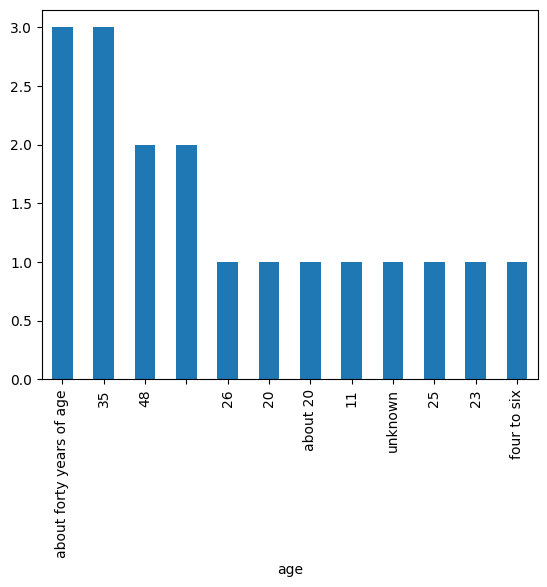

In [ ]:
df_bios.age.value_counts().plot(kind='bar')

If you want to learn more about improving structured generation, I can recommend [this tutorial](https://huggingface.co/learn/cookbook/en/structured_generation).

Also, researchers are currently investigating to what extent forcing  LLMs to generate information in a specified format, lowers the quality of the outputs.

#### Question: How would you improve the prompt?

### GraphRAG

A recent topic of interest is [GraphRAG](https://arxiv.org/abs/2404.16130).

To make sense of large set of documents, we convert the corpus to a network of information. For example, we will convert statements "I got to home" to (subject, predicate, object) triples such as ("I", "go", "home"). Then we detect clusters in the network which we can  use to generate more answers to complex queries such as "what was the age of people involved in bike-accidents" etc.

There is more to this. But here. I'd just like to focus on the first part, the conversion of content to triples.

In [ ]:
tqdm.pandas() # use tqdm to view progress

system_message = """You are a document will clean and correct snippets of newspaper articles that mention the word 'accident'.
    Remove all text that is not about accidents, i.e. mention other events or facts that are not about accidents.
    Try to correct errors in the text wherever possible.
    Examples are:
    Input: "RAILWAY ACCIDENTS IN AMERICA. The record of fatal accidents on the railroads in Eng- land, which is published annually,
            POOR T,i,ENIPAT A 1„k CT  The Poor Law Coirdnissioti(rs have issued a ei; cular, dated the 20th instant, stating that they have consulted the Attorney and"
    Output: "RAILWAY ACCIDENTS IN AMERICA. The record of fatal accidents on the railroads in England, which is published annually."

    Input: "LATEST INTELL IGEN CE. the prisoner was committed for trial for embezzlement. He was also further committed in two"
    Output: ""

    """

df_small['clean'] =  df_small.progress_apply(apply_completions,system_message=system_message, axis=1)

100%|██████████| 25/25 [01:47<00:00,  4.30s/it]


In [ ]:
#df_small = pd.read_json('https://raw.githubusercontent.com/kasparvonbeelen/uga-llm-workshop/refs/heads/main/newspapers/articles_with_graph.json')

Let's therefore clean our data first.

In [ ]:
df_small['clean_article'] = df_small['clean'].apply(lambda x: x.split(':\n\n')[-1].strip('#'))
df_small['clean_article']

,clean_article
221165,"FATAL BOAT ACCIDENT.—GREAX YARMOUTH, Tuesday.—A sad accident occurred at Gorleston yesterday aft..."
400564,"""###persons and injury to 161 persons, making together in the course of 3 years 90 accidents fro..."
403075,"""There were 7 accidents ; 1 passenger was killed by his own m'sconduct, and 37 were injured from..."
52380,"""ACCIDENT.—On the 3rd inst., a few days ago, an extraordinary accident occurred when the Venus, ..."
47646,DEATH FROM SUNSTROKE.—On the 20th inst. an inquest was held at the Poplar Hospital upon the body...
711811,"THE BRIGHTON RAILWAY ACCIDENT.—On Wednesday, Mr. W. Carter concluded the inquiry, at Streat-ham,..."
1840,"A shocking and fatal accident has happened at Accrington Station to Mr. M. Bartle, a cabinetmake..."
786012,"""The truth of the statement has never been disputed on adequate authority, and no practical seam..."
446088,ACCIDENT IN THE METROPOLIS. DT. Lankester held an inquest at Middlesex Hospital on the body of a...
786013,"* Added a comma after ""engine"" in the sentence ""The boiler of an engine bursts...""\n* Changed ""I..."


And then write a new system prompt. In this case, use one provided by [this excellent tutorial](https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a).

In [ ]:
# prompt borrowed from https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a
system_message = """You are a network graph maker who extracts terms and their relations from a given context. "
    "You are provided with a context chunk (delimited by ```) Your task is to extract the ontology "
    "of terms mentioned in the given context. These terms should represent the key concepts as per the context. \n"
    "Thought 1: While traversing through each sentence, Think about the key terms mentioned in it.\n"
        "\tTerms may include object, entity, location, organization, person, \n"
        "\tcondition, acronym, documents, service, concept, etc.\n"
        "\tTerms should be as atomistic as possible\n\n"
    "Thought 2: Think about how these terms can have one on one relation with other terms.\n"
        "\tTerms that are mentioned in the same sentence or the same paragraph are typically related to each other.\n"
        "\tTerms can be related to many other terms\n\n"
    "Thought 3: Find out the relation between each such related pair of terms. \n\n"
    "Format your output as a list of json. Each element of the list contains a pair of terms"
    "and the relation between them, like the follwing: \n"
    "```[\n"
    "   {\n"
    '       "node_1": "A concept from extracted ontology",\n'
    '       "node_2": "A related concept from extracted ontology",\n'
    '       "edge": "relationship between the two concepts, node_1 and node_2"\n'
    "   }, {...}\n"
    "]```"
    """

In [ ]:
df_small['graph'] =  df_small.progress_apply(apply_completions,system_message=system_message, text_column='clean_article',  axis=1)

100%|██████████| 25/25 [03:33<00:00,  8.53s/it]


Run the cell below to look at some examples.

In [ ]:
df_small['graph'][:3]

,graph
221165,Here is the extracted ontology of terms and their relations in JSON format:\n\n```\n[\n {\n ...
400564,Here is the extracted ontology of terms and their relations in JSON format:\n\n```\n[\n {\n ...
403075,Here is the extracted ontology of terms and their relations in JSON format:\n\n```\n[\n {\n ...


In [ ]:
def eval_completion_graph(completion: str):
  try:
     return eval(completion.split('```')[1].strip())
  except Exception as e:
    #print(e,completion)
    return []

df_small['json'] = df_small['graph'].apply(eval_completion_graph)

In [ ]:
df_small['json']

,json
221165,"[{'node_1': 'William Todd', 'node_2': 'Beachman', 'edge': 'is'}, {'node_1': 'William Todd', 'nod..."
400564,"[{'node_1': 'persons', 'node_2': 'injury', 'edge': 'affected_by'}, {'node_1': 'injury', 'node_2'..."
403075,"[{'node_1': 'accidents', 'node_2': 'passengers', 'edge': 'related_to'}, {'node_1': 'passengers',..."
52380,"[{'node_1': 'Venus', 'node_2': 'ship', 'edge': 'is'}, {'node_1': 'Venus', 'node_2': 'Bates', 'ed..."
47646,"[{'node_1': 'Charles Solomon', 'node_2': 'Sunstroke', 'edge': 'affected_by'}, {'node_1': 'Charle..."
711811,"[{'node_1': 'Brighton railway accident', 'node_2': 'circumstances', 'edge': 'related_to'}, {'nod..."
1840,"[{'node_1': 'Accrington Station', 'node_2': 'Mr. M. Bartle', 'edge': 'location'}, {'node_1': 'Mr..."
786012,"[{'node_1': 'practical seaman', 'node_2': 'statement', 'edge': 'believes'}, {'node_1': 'nation',..."
446088,"[{'node_1': 'John Timbs', 'node_2': 'young man', 'edge': 'is a'}, {'node_1': 'John Timbs', 'node..."
786013,[]


In [ ]:
knowledge_graph = []
for g in df_small['json'].to_list():
      for e in g:
        knowledge_graph.append((e['node_1'],e['edge'],e['node_2']))
graph_df = pd.DataFrame(knowledge_graph, columns=['node1','relation','node2'])
graph_df

,node1,relation,node2
0,William Todd,is,Beachman
1,William Todd,located_in,Gorleston
2,William Todd,related_to,Harbour
3,William Todd,used,Boat
4,Enfield Todd,is,Beachman
...,...,...,...
244,Windermere,location,Manchester excursion train
245,Windermere,location,station
246,Garston,location,passenger train
247,Garston,location,siding


In [ ]:
graph_df['relation'].value_counts()[:20]

,count
relation,
location,15
is a,10
related_to,8
related to,8
located_in,7
is,6
caused_by,5
affected_by,5
occupation,4


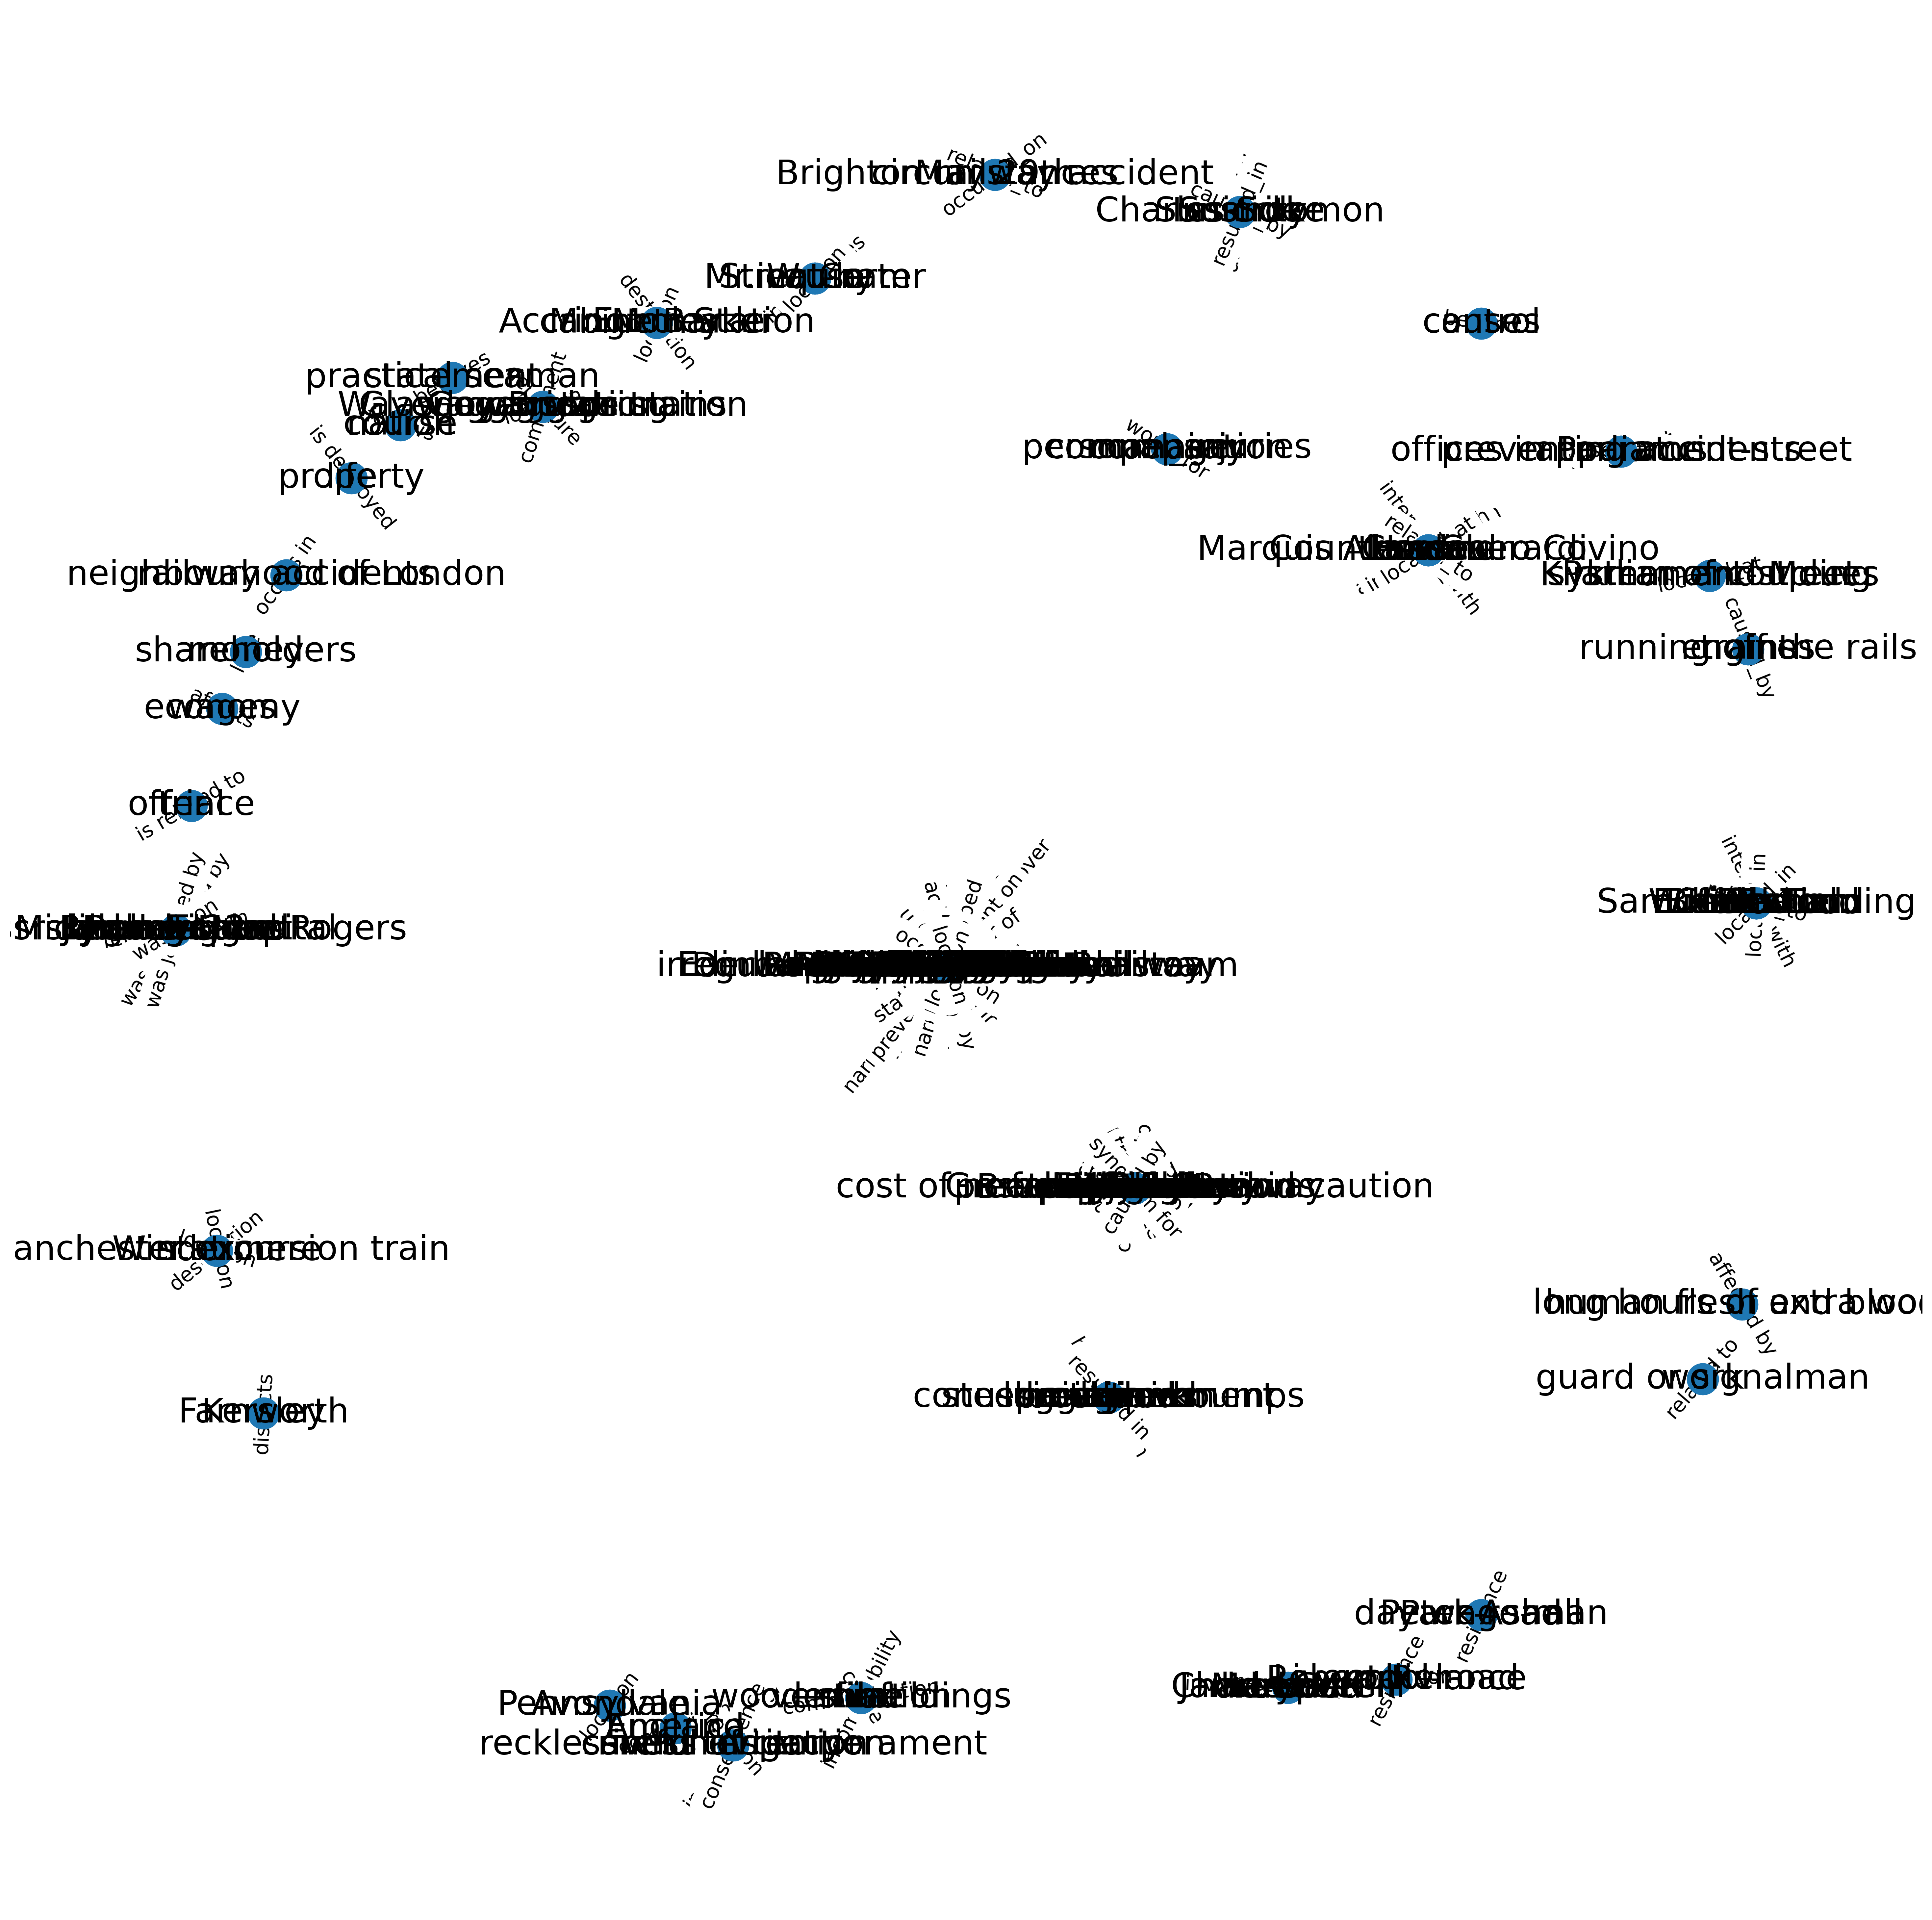

In [ ]:
# Create directed graph
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
triples = []
for node1, relation, node2 in knowledge_graph:
  #if "location" in relation:
      triples.append((node1, relation, node2))
      G.add_edge(node1, node2, label=relation)

# Plot the graph
plt.figure(figsize=(25, 25), dpi=300)
#pos = nx.spring_layout(G, k=2, iterations=10, seed=0)
pos = nx.kamada_kawai_layout(G,scale=3)

nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edge_color='gray', edgelist=G.edges(), width=2)
nx.draw_networkx_labels(G, pos, font_size=25)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)

# Display the plot
plt.axis('off')
plt.show()

## Exercise

Experiment with your own system message! Have fun :-)

In [ ]:
# enter code here

# What if things don't work?

- Use larger models (see example below for using the OpenAI API)
- Model fine-tuning on real or synthetic data. An example [here](https://huggingface.co/blog/mlabonne/sft-llama3)

In [ ]:
!pip install openai

In [ ]:
import openai

In [ ]:
df_chunks.iloc[4]['chunks']

"from Harrow; Mr. and Miss Afansergh, at Gould's Hotel, Jermyn-street, from Paris; Captain Patterson, at ditto, from Bath ; Samuel Peach, Esq., at Burlington Hotel, Old Burlington and Cork.:streets, from Warwickshire ; J. Cano, Esq. at ditto, from Ireland. CUANGEL—The Earl and Countess of Sefton and the Ladies Molyneux, for their seat, Stoke Farm, Berke ; the Countess of Mansfield, for her Villa at Twickenham ; Lord Lynedock, from his seat, Cosgrove Priory, for the Marquis of Anglesey's, Beau Desert, Staffordshire; Lord Meneaster, from Melton Mowbray, for his seat, in Cumberland ; Augustus Atkyns, Esq. from Farnborough Hill, near Bagshot, to Arreton Vicarage, near Newport, Isle of Wight; the Rev. Dr. Wynne, from Warne's Hotel; Mrs. Fletcher and family, from ditto; Mrs. Walker and family, from ditto, for North Wales; the Countess of Golflird, from the St. George's Hotel, Albemarle-street, for her seat, Brompton Park, Huntingdon. The Marchioness Dowager of Salisbury's Convex.sazione, on 

In [ ]:
from openai import OpenAI
client = OpenAI(api_key='sk-...')

In [ ]:
completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": "You are a helpful assistant. Correct the text below."},
    {"role": "user", "content": df_chunks.iloc[4]['chunks']}
  ]
)



In [ ]:
print(completion.choices[0].message.content)

From Harrow; Mr. and Miss Afansergh, at Gould's Hotel, Jermyn Street, from Paris; Captain Patterson, at the same, from Bath; Samuel Peach, Esq., at Burlington Hotel, Old Burlington and Cork Streets, from Warwickshire; J. Cano, Esq., at the same, from Ireland.

CHANGES—The Earl and Countess of Sefton and the Ladies Molyneux, for their seat, Stoke Farm, Berkshire; the Countess of Mansfield, for her villa at Twickenham; Lord Lynedoch, from his seat, Cosgrove Priory, for the Marquis of Anglesey's Beau Desert, Staffordshire; Lord Meneaster, from Melton Mowbray, for his seat in Cumberland; Augustus Atkyns, Esq., from Farnborough Hill, near Bagshot, to Arreton Vicarage, near Newport, Isle of Wight; the Rev. Dr. Wynne, from Warne's Hotel; Mrs. Fletcher and family, from the same; Mrs. Walker and family, from the same, for North Wales; the Countess of Gifford, from the St. George's Hotel, Albemarle Street, for her seat, Brompton Park, Huntingdon.

The Marchioness Dowager of Salisbury's conversaz

# Fin.